In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import datetime as dt

In [3]:
customers_df= pd.read_csv('C:/Users/Admin/Downloads/olist_customers_dataset.csv')
geolocation_df= pd.read_csv("C:/Users/Admin/Downloads/olist_geolocation_dataset.csv")
items_df= pd.read_csv('C:/Users/Admin/Downloads/olist_order_items_dataset.csv')
payments_df= pd.read_csv('C:/Users/Admin/Downloads/olist_order_payments_dataset.csv')
reviews_df= pd.read_csv('C:/Users/Admin/Downloads/olist_order_reviews_dataset.csv')
orders_df= pd.read_csv('C:/Users/Admin/Downloads/olist_orders_dataset.csv')
products_df= pd.read_csv('C:/Users/Admin/Downloads/olist_products_dataset.csv')
sellers_df= pd.read_csv('C:/Users/Admin/Downloads/olist_sellers_dataset.csv')
category_translation_df= pd.read_csv('C:/Users/Admin/Downloads/product_category_name_translation.csv')

# Data Preprocessing

Check null-value and duplicates

In [4]:
datasets = [customers_df, geolocation_df, items_df, payments_df, reviews_df, orders_df, products_df, sellers_df, category_translation_df]
titles = ["customers", "geolocation", "items", "payments", "reviews", "orders", "products", "sellers", "category_translation"]

data_summary = pd.DataFrame({},)
data_summary['datasets']= titles
data_summary['columns'] = [', '.join([col for col, null in data.isnull().sum().items() ]) for data in datasets]
data_summary['total_rows']= [data.shape[0] for data in datasets]
data_summary['total_cols']= [data.shape[1] for data in datasets]
data_summary['total_duplicate']= [len(data[data.duplicated()]) for data in datasets]
data_summary['total_null']= [data.isnull().sum().sum() for data in datasets]
data_summary['null_cols'] = [', '.join([col for col, null in data.isnull().sum().items() if null > 0]) for data in datasets]
data_summary.style.background_gradient(cmap='YlGnBu')

,datasets,columns,total_rows,total_cols,total_duplicate,total_null,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441,5,0,0,
1,geolocation,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",1000163,5,261831,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650,7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886,5,0,0,
4,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",99224,7,0,145903,"review_comment_title, review_comment_message"
5,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",99441,8,0,4908,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
6,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951,9,0,2448,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095,4,0,0,
8,category_translation,"product_category_name, product_category_name_english",71,2,0,0,


Drop null and duplicates

In [5]:
for i in datasets:
    i.dropna(inplace=True)

In [6]:
for i in datasets:
    i.drop(i[i.duplicated()].index, axis=0, inplace=True)

In [7]:
data_summary = pd.DataFrame({},)
data_summary['datasets']= titles
data_summary['columns'] = [', '.join([col for col, null in data.isnull().sum().items() ]) for data in datasets]
data_summary['total_rows']= [data.shape[0] for data in datasets]
data_summary['total_cols']= [data.shape[1] for data in datasets]
data_summary['total_duplicate']= [len(data[data.duplicated()]) for data in datasets]
data_summary['total_null']= [data.isnull().sum().sum() for data in datasets]
data_summary['null_cols'] = [', '.join([col for col, null in data.isnull().sum().items() if null > 0]) for data in datasets]
data_summary.style.background_gradient(cmap='YlGnBu')

,datasets,columns,total_rows,total_cols,total_duplicate,total_null,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441,5,0,0,
1,geolocation,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",738332,5,0,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650,7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886,5,0,0,
4,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",9839,7,0,0,
5,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",96461,8,0,0,
6,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32340,9,0,0,
7,sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095,4,0,0,
8,category_translation,"product_category_name, product_category_name_english",71,2,0,0,


In [8]:
merged_df= pd.merge(customers_df, orders_df, on="customer_id")
merged_df= merged_df.merge(reviews_df, on="order_id")
merged_df= merged_df.merge(items_df, on="order_id")
merged_df= merged_df.merge(products_df, on="product_id")
merged_df= merged_df.merge(payments_df, on="order_id")
merged_df= merged_df.merge(sellers_df, on='seller_id')
merged_df= merged_df.merge(category_translation_df, on='product_category_name')
merged_df.shape

(11578, 40)

In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11578 entries, 0 to 11577
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    11578 non-null  object 
 1   customer_unique_id             11578 non-null  object 
 2   customer_zip_code_prefix       11578 non-null  int64  
 3   customer_city                  11578 non-null  object 
 4   customer_state                 11578 non-null  object 
 5   order_id                       11578 non-null  object 
 6   order_status                   11578 non-null  object 
 7   order_purchase_timestamp       11578 non-null  object 
 8   order_approved_at              11578 non-null  object 
 9   order_delivered_carrier_date   11578 non-null  object 
 10  order_delivered_customer_date  11578 non-null  object 
 11  order_estimated_delivery_date  11578 non-null  object 
 12  review_id                      11578 non-null 

convert time columns to pd.datetime

In [11]:
time_columns= ['order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date','order_delivered_customer_date',
               'order_estimated_delivery_date', 'review_creation_date', 'review_answer_timestamp', 'shipping_limit_date']

In [12]:
merged_df[time_columns]=merged_df[time_columns].apply(pd.to_datetime)

In [13]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11578 entries, 0 to 11577
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    11578 non-null  object        
 1   customer_unique_id             11578 non-null  object        
 2   customer_zip_code_prefix       11578 non-null  int64         
 3   customer_city                  11578 non-null  object        
 4   customer_state                 11578 non-null  object        
 5   order_id                       11578 non-null  object        
 6   order_status                   11578 non-null  object        
 7   order_purchase_timestamp       11578 non-null  datetime64[ns]
 8   order_approved_at              11578 non-null  datetime64[ns]
 9   order_delivered_carrier_date   11578 non-null  datetime64[ns]
 10  order_delivered_customer_date  11578 non-null  datetime64[ns]
 11  order_estimated

# RFM Analysis

In [14]:
present_day = merged_df['order_purchase_timestamp'].max() + dt.timedelta(days=2)
present_day

Timestamp('2018-08-31 14:18:28')

In [15]:
print("Latest date in dataset: ", merged_df['order_purchase_timestamp'].max())

Latest date in dataset:  2018-08-29 14:18:28


define "Recency", "Frequency", "Monetary" values

In [16]:
recency_df= pd.DataFrame(merged_df.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max())
recency_df

,customer_unique_id,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,000ec5bff359e1c0ad76a81a45cb598f,2018-08-21 11:34:26
2,00172711b30d52eea8b313a7f2cced02,2018-07-28 00:23:49
3,001928b561575b2821c92254a2327d06,2018-08-24 21:17:00
4,0019e8c501c85848ac0966d45226fa1d,2018-05-01 09:25:32
...,...,...
9328,ffeb904468642a1ce663a322629801cb,2018-06-27 11:57:41
9329,ffecceca389973ef16660d58696f281e,2018-04-25 12:08:11
9330,fff2ae16b99c6f3c785f0e052f2a9cfb,2018-04-20 11:03:47
9331,fff3e1d7bc75f11dc7670619b2e61840,2018-07-20 13:47:30


In [17]:
recency_df['Recency']= recency_df['order_purchase_timestamp'].apply(lambda x: (present_day - x).days)
recency_df

,customer_unique_id,order_purchase_timestamp,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,113
1,000ec5bff359e1c0ad76a81a45cb598f,2018-08-21 11:34:26,10
2,00172711b30d52eea8b313a7f2cced02,2018-07-28 00:23:49,34
3,001928b561575b2821c92254a2327d06,2018-08-24 21:17:00,6
4,0019e8c501c85848ac0966d45226fa1d,2018-05-01 09:25:32,122
...,...,...,...
9328,ffeb904468642a1ce663a322629801cb,2018-06-27 11:57:41,65
9329,ffecceca389973ef16660d58696f281e,2018-04-25 12:08:11,128
9330,fff2ae16b99c6f3c785f0e052f2a9cfb,2018-04-20 11:03:47,133
9331,fff3e1d7bc75f11dc7670619b2e61840,2018-07-20 13:47:30,42


In [18]:
frequency_df = pd.DataFrame(merged_df.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}).reset_index())
frequency_df.rename(columns={"order_id":"Frequency"}, inplace=True)
frequency_df

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,000ec5bff359e1c0ad76a81a45cb598f,1
2,00172711b30d52eea8b313a7f2cced02,1
3,001928b561575b2821c92254a2327d06,1
4,0019e8c501c85848ac0966d45226fa1d,1
...,...,...
9328,ffeb904468642a1ce663a322629801cb,1
9329,ffecceca389973ef16660d58696f281e,1
9330,fff2ae16b99c6f3c785f0e052f2a9cfb,1
9331,fff3e1d7bc75f11dc7670619b2e61840,1


In [19]:
monetary_df = merged_df.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
monetary_df.columns = ['customer_unique_id', 'Monetary']
monetary_df.head()

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,000ec5bff359e1c0ad76a81a45cb598f,27.75
2,00172711b30d52eea8b313a7f2cced02,122.07
3,001928b561575b2821c92254a2327d06,329.62
4,0019e8c501c85848ac0966d45226fa1d,197.27


In [20]:
RF_df = recency_df.merge(frequency_df, on='customer_unique_id')
RFM_df = RF_df.merge(monetary_df, on='customer_unique_id').drop(columns='order_purchase_timestamp')
RFM_df.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90
1,000ec5bff359e1c0ad76a81a45cb598f,10,1,27.75
2,00172711b30d52eea8b313a7f2cced02,34,1,122.07
3,001928b561575b2821c92254a2327d06,6,1,329.62
4,0019e8c501c85848ac0966d45226fa1d,122,1,197.27


In [23]:
RFM_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,9333.0,74.851709,42.532132,2.00,37.00,75.00,112.00,483.00
Frequency,9333.0,1.011036,0.108502,1.00,1.00,1.00,1.00,3.00
Monetary,9333.0,245.638111,641.607276,13.89,68.18,122.42,217.55,29099.52


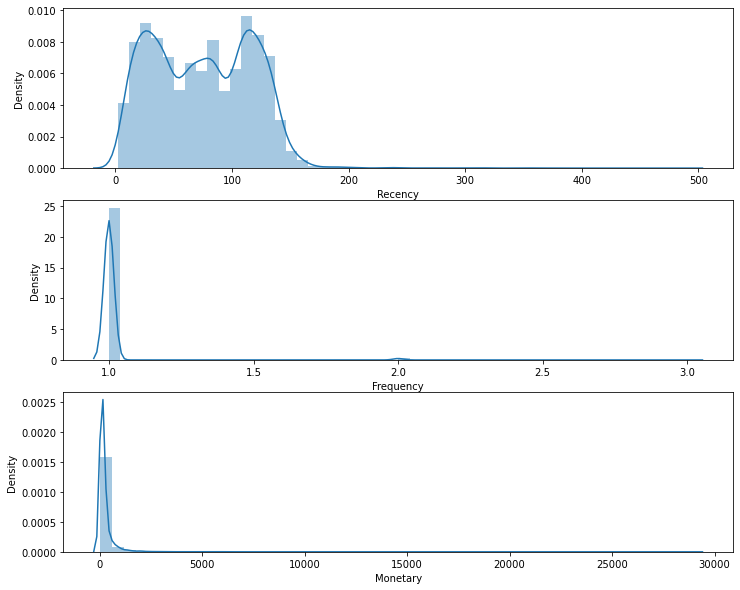

In [24]:
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1); sns.distplot(RFM_df['Recency'])
plt.subplot(3, 1, 2); sns.distplot(RFM_df['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(RFM_df['Monetary'])
plt.show()

In [25]:
RFM_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9333 entries, 0 to 9332
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  9333 non-null   object 
 1   Recency             9333 non-null   int64  
 2   Frequency           9333 non-null   int64  
 3   Monetary            9333 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 364.6+ KB


In [27]:
RFM_df2= RFM_df.copy()
RFM_df2= RFM_df2.set_index('customer_unique_id')
RFM_df2

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90
000ec5bff359e1c0ad76a81a45cb598f,10,1,27.75
00172711b30d52eea8b313a7f2cced02,34,1,122.07
001928b561575b2821c92254a2327d06,6,1,329.62
0019e8c501c85848ac0966d45226fa1d,122,1,197.27
...,...,...,...
ffeb904468642a1ce663a322629801cb,65,1,93.11
ffecceca389973ef16660d58696f281e,128,1,72.76
fff2ae16b99c6f3c785f0e052f2a9cfb,133,1,200.90


RFM Segments

In [28]:
RFM_df2["recency_score"]  = pd.qcut(RFM_df2['Recency'], 5, labels=[5, 4, 3, 2, 1])
RFM_df2["frequency_score"]= pd.qcut(RFM_df2['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
RFM_df2["monetary_score"] = pd.qcut(RFM_df2['Monetary'], 5, labels=[1, 2, 3, 4, 5])

In [29]:
RFM_df2['RFM_SCORE'] = RFM_df2.recency_score.astype(str)+ RFM_df2.frequency_score.astype(str) + RFM_df2.monetary_score.astype(str)
RFM_df2

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,2,1,3,213
000ec5bff359e1c0ad76a81a45cb598f,10,1,27.75,5,1,1,511
00172711b30d52eea8b313a7f2cced02,34,1,122.07,4,1,3,413
001928b561575b2821c92254a2327d06,6,1,329.62,5,1,5,515
0019e8c501c85848ac0966d45226fa1d,122,1,197.27,1,1,4,114
...,...,...,...,...,...,...,...
ffeb904468642a1ce663a322629801cb,65,1,93.11,3,5,2,352
ffecceca389973ef16660d58696f281e,128,1,72.76,1,5,2,152
fff2ae16b99c6f3c785f0e052f2a9cfb,133,1,200.90,1,5,4,154


In [30]:
seg_map= {
    r'111|112|121|131|141|151': 'Lost customers',
    r'332|322|233|232|223|222|132|123|122|212|211': 'Hibernating customers', 
    r'155|154|144|214|215|115|114|113': 'Cannot Lose Them',
    r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124': 'At Risk',
    r'331|321|312|221|213|231|241|251': 'About To Sleep',
    r'535|534|443|434|343|334|325|324': 'Need Attention',
    r'525|524|523|522|521|515|514|513|425|424|413|414|415|315|314|313': 'Promising',
    r'512|511|422|421|412|411|311': 'New Customers',
    r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323': 'Potential Loyalist',
    r'543|444|435|355|354|345|344|335': 'Loyal',
    r'555|554|544|545|454|455|445': 'Champions'
}

In [31]:
RFM_df2['Segment'] = RFM_df2['recency_score'].astype(str) + RFM_df2['frequency_score'].astype(str) + RFM_df2['monetary_score'].astype(str)
RFM_df2['Segment'] = RFM_df2['Segment'].replace(seg_map, regex=True)
RFM_df2.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,Segment
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,2,1,3,213,About To Sleep
000ec5bff359e1c0ad76a81a45cb598f,10,1,27.75,5,1,1,511,New Customers
00172711b30d52eea8b313a7f2cced02,34,1,122.07,4,1,3,413,Promising
001928b561575b2821c92254a2327d06,6,1,329.62,5,1,5,515,Promising
0019e8c501c85848ac0966d45226fa1d,122,1,197.27,1,1,4,114,Cannot Lose Them


In [32]:
RFM_df2['Segment'].unique()

array(['About To Sleep', 'New Customers', 'Promising', 'Cannot Lose Them',
       'Hibernating customers', 'Lost customers', 'Champions', 'At Risk',
       'Potential Loyalist', 'Loyal', 'Need Attention'], dtype=object)

In [33]:
RFM_df2['Segment'].nunique()

11

In [34]:
RFMStats = RFM_df2[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg(['mean','median', 'min', 'max', 'count'])
RFMStats

Recency                        Frequency             \
                             mean median  min  max count      mean median min   
Segment                                                                         
About To Sleep          93.675127   97.0   61  117   591  1.001692    1.0   1   
At Risk                118.162048  116.0   89  360  1660  1.012651    1.0   1   
Cannot Lose Them       125.725522  125.0   89  483   623  1.009631    1.0   1   
Champions               30.232000   29.0    2   60   500  1.088000    1.0   1   
Hibernating customers  108.001267  108.0   61  441   789  1.000000    1.0   1   
Lost customers         131.985149  129.0  118  261   404  1.000000    1.0   1   
Loyal                   61.349481   67.0    2   88   578  1.024221    1.0   1   
Need Attention          52.870175   58.0    2   88   570  1.000000    1.0   1   
New Customers           41.005535   39.0    2   88   542  1.000000    1.0   1   
Potential Loyalist      43.639805   40.0    2   88  1849  1.009194    1.0   1   
Promising               37.971475   31.0    2   88  1227  1.000000    1.0   1   

                                   Monetary                                   
                      max count        mean   median     min       max count  
Segment                                                                       
About To Sleep          2   591   56.405262   47.530   14.38    150.60   591  
At Risk                 3  1660  376.492669  180.170   59.22  19457.04  1660  
Cannot Lose Them        2   623  433.820353  215.270   98.43  19174.38   623  
Champions               3   500  448.646360  312.925  151.42   5948.36   500  
Hibernating customers   1   789   88.238314   86.420   16.29    151.33   789  
Lost customers          1   404   48.506584   47.230   17.29     97.38   404  
Loyal                   2   578  549.842872  267.860   98.56  29099.52   578  
Need Attention          1   570  302.168316  186.820   98.65   5398.75   570  
New Customers           1   542   57.508506   55.005   14.29     98.26   542  
Potential Loyalist      2  1849   80.308183   76.580   13.89    151.14  1849  
Promising               1  1227  310.279250  181.690   18.70  11468.45  1227

In [35]:
RFMStats['Ratio']= (100*RFMStats['Monetary']["count"]/RFMStats['Monetary']["count"].sum()).round(2)
RFMStats

Recency                        Frequency             \
                             mean median  min  max count      mean median min   
Segment                                                                         
About To Sleep          93.675127   97.0   61  117   591  1.001692    1.0   1   
At Risk                118.162048  116.0   89  360  1660  1.012651    1.0   1   
Cannot Lose Them       125.725522  125.0   89  483   623  1.009631    1.0   1   
Champions               30.232000   29.0    2   60   500  1.088000    1.0   1   
Hibernating customers  108.001267  108.0   61  441   789  1.000000    1.0   1   
Lost customers         131.985149  129.0  118  261   404  1.000000    1.0   1   
Loyal                   61.349481   67.0    2   88   578  1.024221    1.0   1   
Need Attention          52.870175   58.0    2   88   570  1.000000    1.0   1   
New Customers           41.005535   39.0    2   88   542  1.000000    1.0   1   
Potential Loyalist      43.639805   40.0    2   88  1849  1.009194    1.0   1   
Promising               37.971475   31.0    2   88  1227  1.000000    1.0   1   

                                   Monetary                                   \
                      max count        mean   median     min       max count   
Segment                                                                        
About To Sleep          2   591   56.405262   47.530   14.38    150.60   591   
At Risk                 3  1660  376.492669  180.170   59.22  19457.04  1660   
Cannot Lose Them        2   623  433.820353  215.270   98.43  19174.38   623   
Champions               3   500  448.646360  312.925  151.42   5948.36   500   
Hibernating customers   1   789   88.238314   86.420   16.29    151.33   789   
Lost customers          1   404   48.506584   47.230   17.29     97.38   404   
Loyal                   2   578  549.842872  267.860   98.56  29099.52   578   
Need Attention          1   570  302.168316  186.820   98.65   5398.75   570   
New Customers           1   542   57.508506   55.005   14.29     98.26   542   
Potential Loyalist      2  1849   80.308183   76.580   13.89    151.14  1849   
Promising               1  1227  310.279250  181.690   18.70  11468.45  1227   

                       Ratio  
                              
Segment                       
About To Sleep          6.33  
At Risk                17.79  
Cannot Lose Them        6.68  
Champions               5.36  
Hibernating customers   8.45  
Lost customers          4.33  
Loyal                   6.19  
Need Attention          6.11  
New Customers           5.81  
Potential Loyalist     19.81  
Promising              13.15

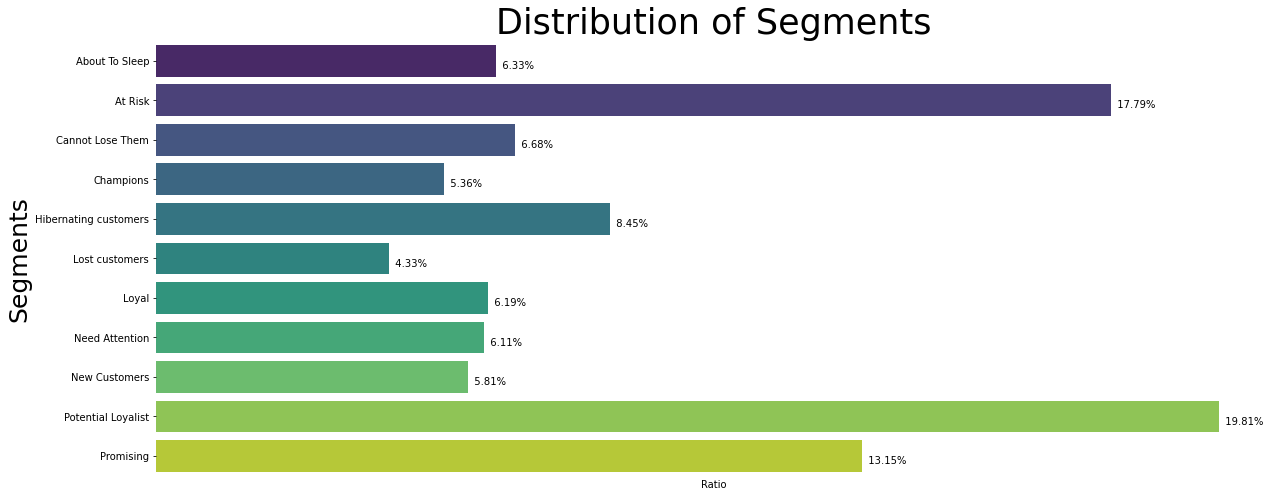

In [36]:
plt.figure(figsize=(20,8))
#plt.rc('font', size=20)
per= sns.barplot(x=RFMStats['Ratio'], y=RFMStats.index, data=RFMStats, palette="viridis")
sns.despine(bottom = True, left = True)
for i, v in enumerate(RFMStats['Ratio']):
    per.text(v, i+.20,"  {:.2f}".format(v)+"%", color='black', ha="left")
per.set_ylabel('Segments', fontsize=25)
per.set(xticks=[])
plt.title('Distribution of Segments', fontsize=35)
plt.show()

In [37]:
!pip install squarify
import squarify

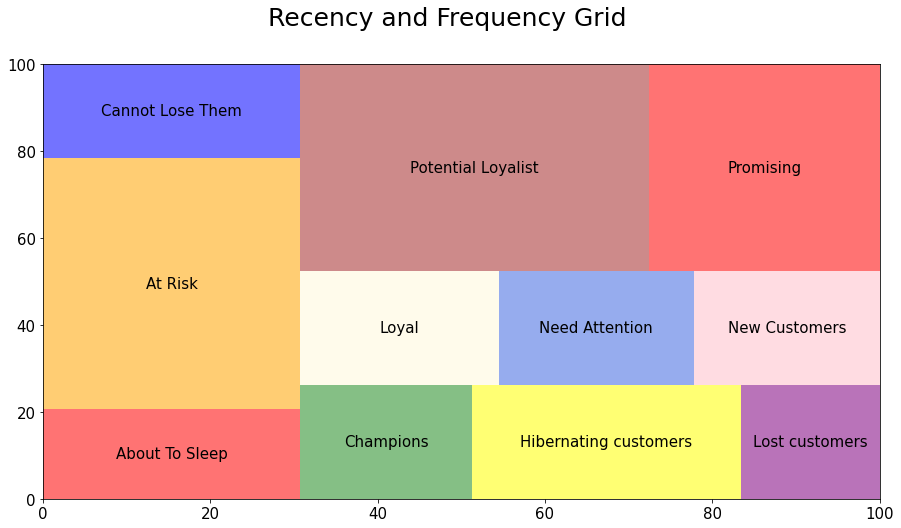

In [38]:
# Treemap by recency/frequency
plt.figure(figsize=(15,8))
plt.rc('font', size=15)
squarify.plot(sizes=RFMStats["Recency"]["count"], label=RFMStats.index, 
              color=["red","orange","blue", "forestgreen", "yellow", "purple", "cornsilk","royalblue", "pink", "brown"], alpha=.55)
plt.suptitle("Recency and Frequency Grid", fontsize=25);

# Clustering with K-Means

In [39]:
RFM_df3= RFM_df2.drop(["recency_score", "frequency_score", "monetary_score", "RFM_SCORE", "Segment"], axis=1)
RFM_df3

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90
000ec5bff359e1c0ad76a81a45cb598f,10,1,27.75
00172711b30d52eea8b313a7f2cced02,34,1,122.07
001928b561575b2821c92254a2327d06,6,1,329.62
0019e8c501c85848ac0966d45226fa1d,122,1,197.27
...,...,...,...
ffeb904468642a1ce663a322629801cb,65,1,93.11
ffecceca389973ef16660d58696f281e,128,1,72.76
fff2ae16b99c6f3c785f0e052f2a9cfb,133,1,200.90


In [40]:
#check if data is skewed
from scipy import stats #library
def check_skew(df, column):
    skew = stats.skew(df[column])
    skewtest = stats.skewtest(df[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df[column])
    plt.show()
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

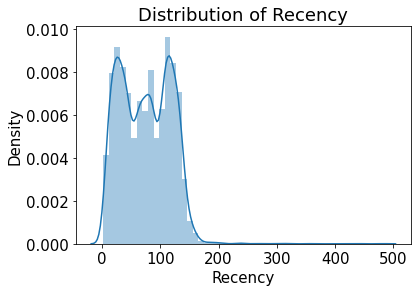

Recency's: Skew: 0.3390555571522835, : SkewtestResult(statistic=13.026296934670588, pvalue=8.671504578917153e-39)


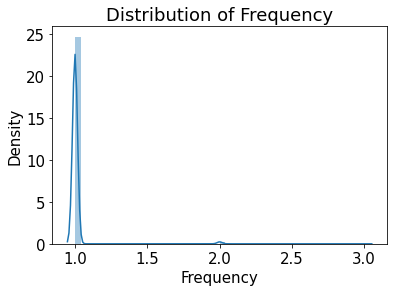

Frequency's: Skew: 10.34835150768159, : SkewtestResult(statistic=104.32160208811939, pvalue=0.0)


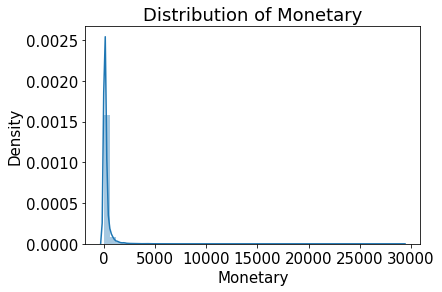

Monetary's: Skew: 20.56920879070542, : SkewtestResult(statistic=126.45061311574032, pvalue=0.0)


In [41]:
for col in RFM_df3.columns:
    check_skew(RFM_df3, col)

In [42]:
RFM_log= RFM_df3.copy()
for i in RFM_log.columns[1:]:
    RFM_log[i] = np.log10(RFM_log[i])

In [43]:
RFM_log

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,0.0,2.151982
000ec5bff359e1c0ad76a81a45cb598f,10,0.0,1.443263
00172711b30d52eea8b313a7f2cced02,34,0.0,2.086609
001928b561575b2821c92254a2327d06,6,0.0,2.518014
0019e8c501c85848ac0966d45226fa1d,122,0.0,2.295061
...,...,...,...
ffeb904468642a1ce663a322629801cb,65,0.0,1.968996
ffecceca389973ef16660d58696f281e,128,0.0,1.861893
fff2ae16b99c6f3c785f0e052f2a9cfb,133,0.0,2.302980


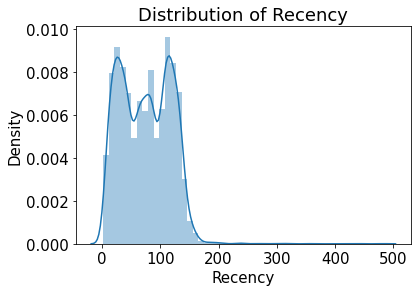

Recency's: Skew: 0.3390555571522835, : SkewtestResult(statistic=13.026296934670588, pvalue=8.671504578917153e-39)


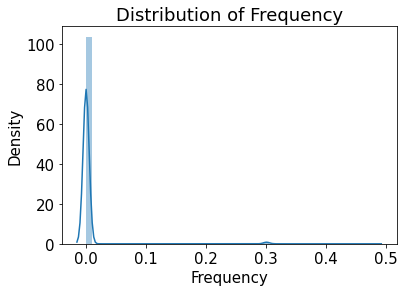

Frequency's: Skew: 9.801873319074893, : SkewtestResult(statistic=102.57673072385273, pvalue=0.0)


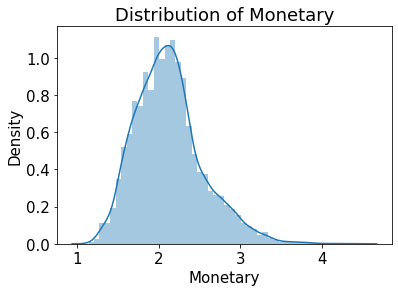

Monetary's: Skew: 0.7508728956678877, : SkewtestResult(statistic=26.54199373691504, pvalue=3.1773250347242865e-155)


In [44]:
for col in RFM_log.columns:
    check_skew(RFM_log, col)

In [45]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()

RFM_log_scaled= scaler.fit_transform(RFM_log)
RFM_log_scaled_df= pd.DataFrame(RFM_log_scaled)
RFM_log_scaled_df.columns = ['recency', 'frequency', 'monetary']
RFM_log_scaled_df.head()

,recency,frequency,monetary
0,0.896977,-0.102887,0.066981
1,-1.524851,-0.102887,-1.638392
2,-0.960542,-0.102887,-0.090325
3,-1.618903,-0.102887,0.947752
4,1.108593,-0.102887,0.411267


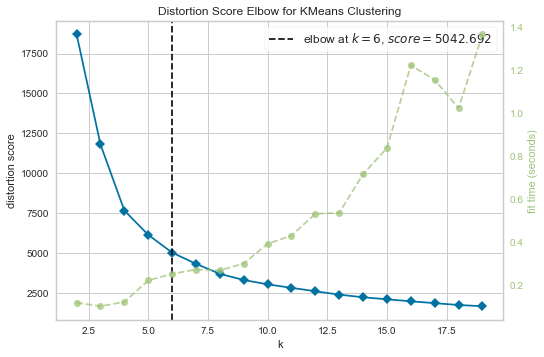

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [46]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
k_means = KMeans()
elbow = KElbowVisualizer(k_means, k=(2, 20))
elbow.fit(RFM_log_scaled_df)
elbow.show()

In [47]:
kmeans= KMeans(n_clusters=elbow.elbow_value_)
kmeans.fit(RFM_log_scaled_df)

KMeans(n_clusters=6)

In [48]:
RFM_log_scaled_df['Cluster']= kmeans.labels_
RFM_log_scaled_df.head()

,recency,frequency,monetary,Cluster
0,0.896977,-0.102887,0.066981,3
1,-1.524851,-0.102887,-1.638392,1
2,-0.960542,-0.102887,-0.090325,0
3,-1.618903,-0.102887,0.947752,0
4,1.108593,-0.102887,0.411267,3


In [49]:
# Function to visualize clusters
def rfm_clusters_stat(df):
    df_new = df.groupby(['Cluster']).agg({
            'Recency'  : ['mean','median', 'min', 'max'],
            'Frequency': ['mean','median', 'min', 'max'],
            'Monetary' : ['mean','median', 'min', 'max', 'count']
        }).round(0)

    return df_new

In [50]:
RFM_df4= RFM_df3.copy()
RFM_df4['Cluster'] = kmeans.labels_
RFM_df4

,Recency,Frequency,Monetary,Cluster
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,3
000ec5bff359e1c0ad76a81a45cb598f,10,1,27.75,1
00172711b30d52eea8b313a7f2cced02,34,1,122.07,0
001928b561575b2821c92254a2327d06,6,1,329.62,0
0019e8c501c85848ac0966d45226fa1d,122,1,197.27,3
...,...,...,...,...
ffeb904468642a1ce663a322629801cb,65,1,93.11,1
ffecceca389973ef16660d58696f281e,128,1,72.76,5
fff2ae16b99c6f3c785f0e052f2a9cfb,133,1,200.90,3


In [51]:
rfm_clusters_stat(RFM_df4).style.background_gradient(cmap='YlGnBu')

In [52]:
RFM_stats= pd.DataFrame(rfm_clusters_stat(RFM_df4))

Text(0.5, 0.98, 'Segments of Customers')

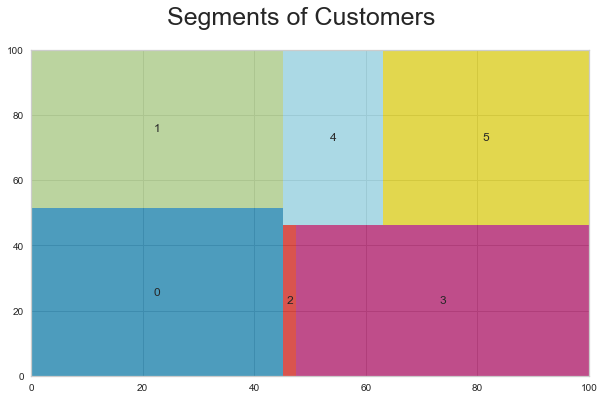

In [53]:
# Visualize Segments
plt.figure(figsize=(10, 6))
squarify.plot(sizes=RFM_stats["Monetary"]["count"], label=RFM_stats.index, color=["b","g","r","m","c", "y"], alpha=0.7)
plt.suptitle("Segments of Customers", fontsize=25)